import tensorflow as tf
from tensorflow.Keras import modelsn layers
import matplotlib.pyplot as plt

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [3]:
# pip install matplotlib

# Data Collection

In [6]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [121]:
# bring data 
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [123]:
class_names = dataset.class_names
class_names

['Early_blight', 'Late_blight', 'healthy']

In [125]:
len(dataset)

68

In [127]:
# 32 images , 256 * 256 , 3 = rpg et on a 3 classe 0 1 et 2
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 255, 255, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


In [129]:
# bch nthahrou ken taswira loula 
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].numpy())


[[[162.90582  160.90582  171.90582 ]
  [128.81645  126.81645  137.81645 ]
  [108.07034  106.07034  117.07034 ]
  ...
  [163.0018   161.0018   175.0018  ]
  [158.04297  156.04297  170.04297 ]
  [153.03915  151.03915  165.03915 ]]

 [[148.61253  146.61253  157.61253 ]
  [ 98.383224  96.383224 107.38329 ]
  [144.12883  142.12883  153.1406  ]
  ...
  [158.95512  156.95512  170.95512 ]
  [164.95905  162.95905  176.95905 ]
  [167.97064  165.97064  179.97064 ]]

 [[100.59103   98.59103  109.610634]
  [117.39228  115.39228  126.42354 ]
  [186.45088  184.45088  197.45088 ]
  ...
  [162.981    160.981    174.981   ]
  [163.965    161.965    175.965   ]
  [163.94124  161.94124  175.94124 ]]

 ...

 [[141.92764  137.92764  152.92764 ]
  [120.15168  116.15168  131.15169 ]
  [135.75694  131.75694  146.75694 ]
  ...
  [180.30263  178.30263  191.30263 ]
  [178.11017  176.11017  189.11017 ]
  [188.95915  186.95915  199.95915 ]]

 [[118.10955  114.10955  129.10956 ]
  [102.42793   98.42793  113.42793 ]


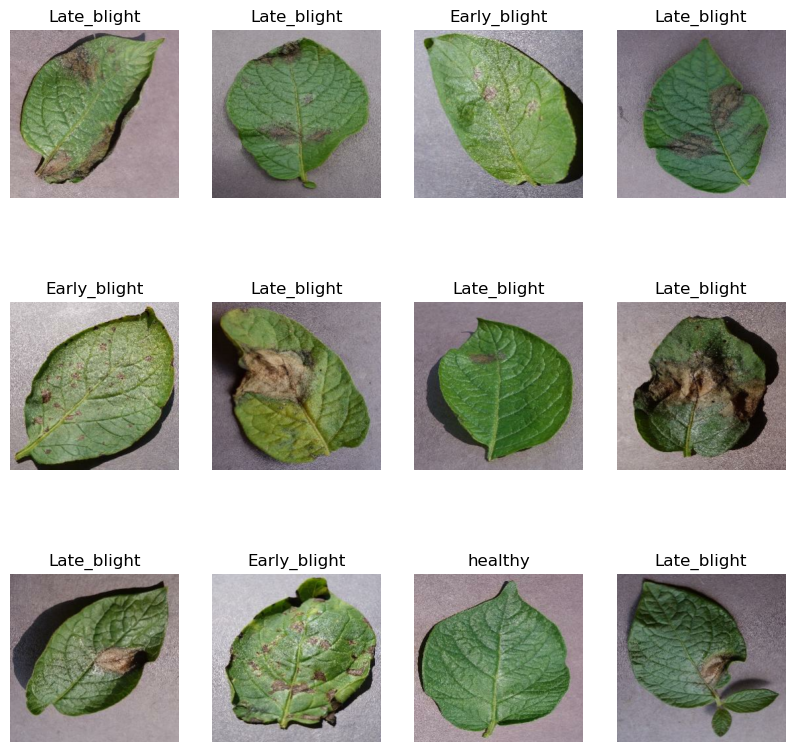

In [131]:
# visualise this image
#hiyya float bch nbadlelha type
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [20]:
len(dataset)

68

In [22]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [24]:
train_ds = dataset.take(54)
len(train_ds)

54

In [26]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [28]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [30]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [32]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [36]:
import numpy as np

In [38]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)
    if shuffle :
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int( val_split * ds_size)

    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds
    

In [40]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [42]:
len(train_ds)

54

In [44]:
len(val_ds)

6

In [46]:
len(test_ds)

8

### Cache, Shuffle, and Prefetch the Dataset

In [49]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

### Building the Model

### Creating a Layer for Resizing and Normalization

In [53]:
print(tf.__version__)

2.18.0


In [55]:
# pip install --upgrade tensorflow

In [59]:
IMAGE_SIZE = 255  # Remplace par la taille désirée
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255),
])

## Data Augmentation

#### Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [63]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

#### Applying Data Augmentation to Train Dataset

In [66]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

#### We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation

In [69]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)   # hauteur largeur rgb
n_classes = 3

model = models.Sequential([      # crée un modèle séquentiel, où les couches sont empilées les unes sur les autres
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

C:\Users\bensa\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [71]:
model.summary() 

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 255, 255, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 253, 253, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 126, 126, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 124, 124, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

### Compiling the Model

In [80]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),    #SparseCategoricalCrossentropy : Cette fonction de perte est utilisée pour les problèmes de classification multi-classes, où les étiquettes de classe sont des entiers (par exemple, 0, 1, 2 pour trois classes).
    metrics=['accuracy']       #  C'est une métrique standard pour évaluer la performance des modèles de classification.
)

In [82]:
#La méthode fit est utilisée pour entraîner le modèle sur les données d'entraînement.
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.4303 - loss: 0.9365 - val_accuracy: 0.6927 - val_loss: 0.7978
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.7124 - loss: 0.6276 - val_accuracy: 0.8542 - val_loss: 0.3513
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.8787 - loss: 0.3177 - val_accuracy: 0.8646 - val_loss: 0.2933
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.8869 - loss: 0.2626 - val_accuracy: 0.9115 - val_loss: 0.2559
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.9133 - loss: 0.2365 - val_accuracy: 0.9479 - val_loss: 0.1888
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.9363 - loss: 0.1691 - val_accuracy: 0.9531 - val_loss: 0.1400
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.9427 - loss: 0.1506 - val_accuracy: 0.9583 - val_loss: 0.1608
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.9373 - loss: 0.1653 - val_accuracy: 0.9479 - val_loss:

In [83]:
scores = model.evaluate(test_ds)
# You can see above that we get 100.00% accuracy for our test dataset. This is considered to be a pretty good accuracy

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 325ms/step - accuracy: 0.9568 - loss: 0.0809


In [86]:
scores

[0.06075926125049591, 0.97265625]

In [88]:
history

In [90]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [92]:
history.history.keys()
# oss, accuracy,val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [94]:
type(history.history['loss'])

list

In [96]:
len(history.history['loss'])

50

In [98]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.8762305378913879,
 0.5332658886909485,
 0.3295535743236542,
 0.2648414671421051,
 0.2367532104253769]

In [100]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

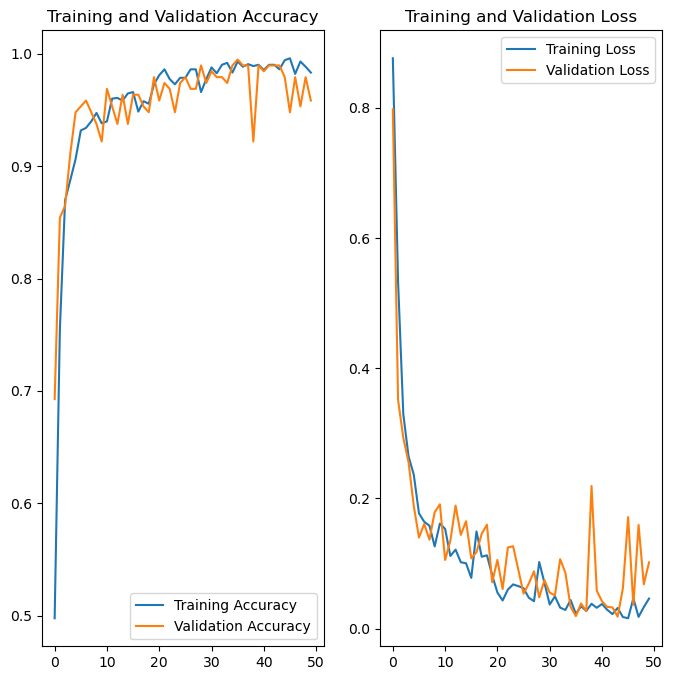

In [102]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#ahayka accurancy mechya w tet7asen w lose mechi w yon9os

### Run prediction on a sample image

first image to predict
actual label: Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
predicted label: Potato___Late_blight


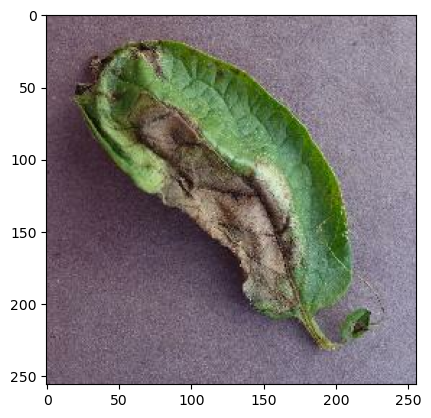

In [105]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

# Test prediction avec le path de l'image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


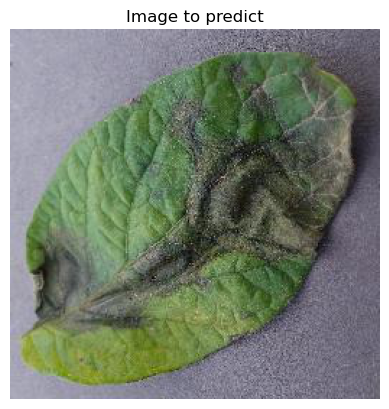

Predicted label: Early_blight


In [135]:
from tensorflow.keras.preprocessing import image
# Fonction pour charger et préparer une image à partir d'un chemin
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    img = image.load_img(image_path, target_size=target_size)  # Charger l'image
    img_array = image.img_to_array(img)  # Convertir en tableau numpy
    img_array = np.expand_dims(img_array, axis=0)  # Ajouter une dimension pour le batch
    img_array = img_array / 255.0  # Normaliser si nécessaire
    return img_array
    
# Spécifier le chemin de l'image à prédire
image_path = "C:/Users/bensa/deeplearningProjet1/projetsss/PlantVillage/Late_blight/0eb24a67-a174-43db-86c7-cca8795942a2___RS_LB 4722.JPG"

# Charger et préparer l'image
img_to_predict = load_and_preprocess_image(image_path)

# Faire la prédiction
batch_prediction = model.predict(img_to_predict)

# Afficher l'image
img = image.load_img(image_path)
plt.imshow(img)
plt.title("Image to predict")
plt.axis("off")  # Masquer les axes
plt.show()

# Afficher le label prédit
predicted_label = class_names[np.argmax(batch_prediction[0])]
print("Predicted label:", predicted_label)

### Write a function for inference

In [108]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


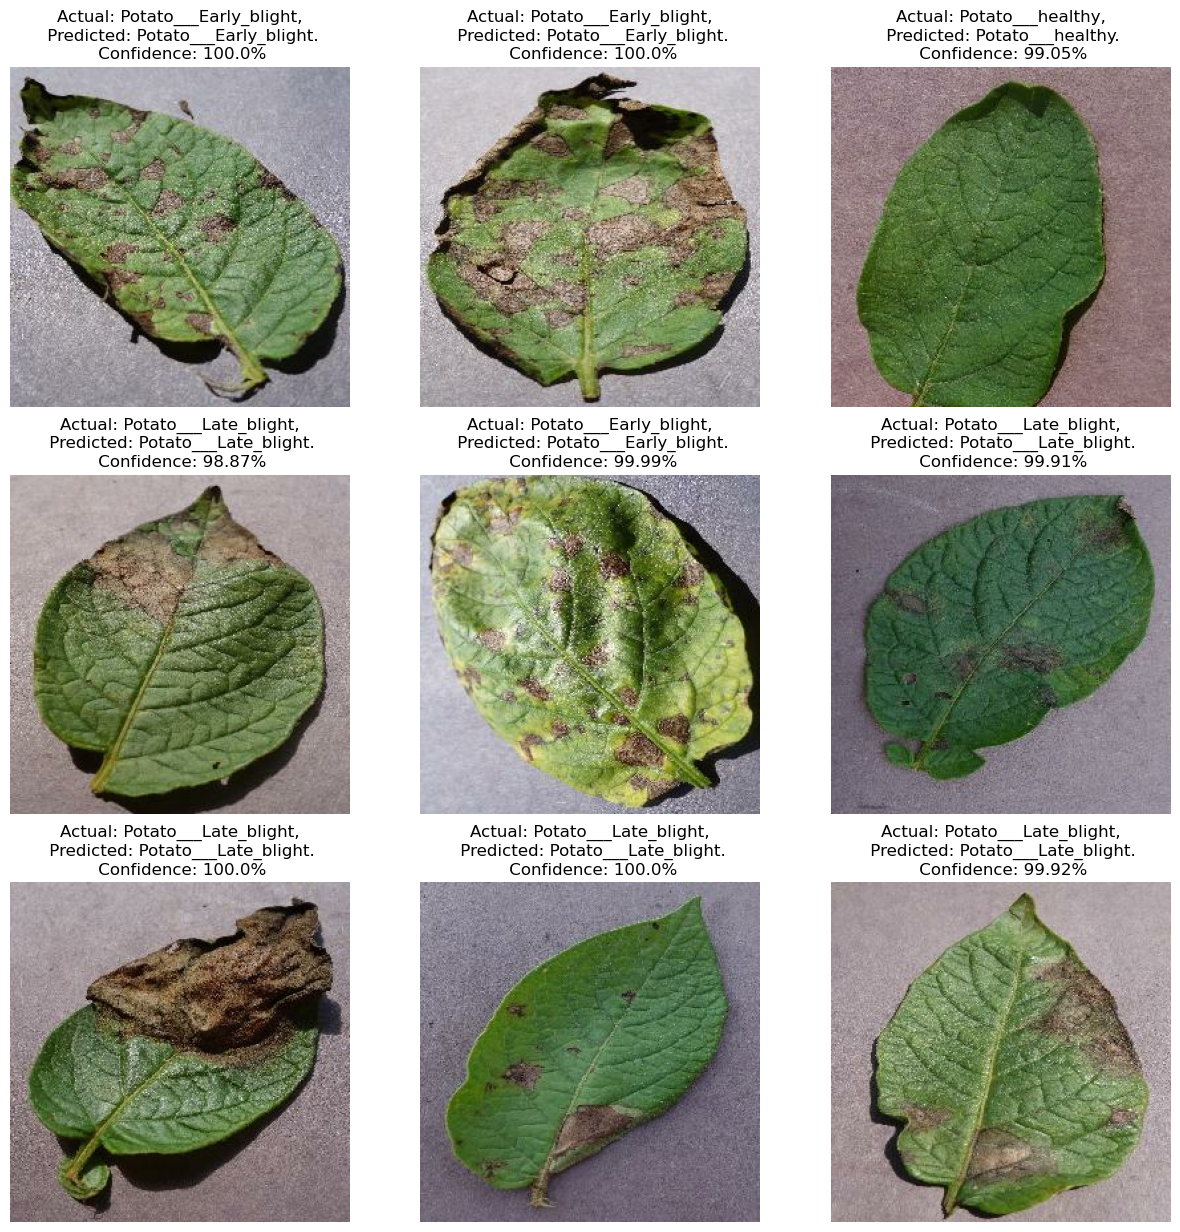

In [110]:
# Now run inference on few sample images 
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")